## !! The final result should be only a runnable .py file !!

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from torch.utils.data import random_split
from models import model_3 as m # our model
from training_early_stop import EarlyStop
import utility
import os

# 0. Data Pre-processing

In [156]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize
])

train_dataset = datasets.ImageFolder(
    '../dataset/train', transform=data_transforms)
# split training set to training set and validation set
# a random seed to ensure reproducibility of results.
torch.manual_seed(42)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.ImageFolder('../dataset/test', transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16, pin_memory=False)

print(len(val_loader), len(train_dataset))

45 25838


In [157]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# 1. Model

In [158]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [159]:
# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.01)

In [160]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = stop_counter + 5 # a range to check stop_counter
different = 0.001 # different between the best val loss and the most recent one
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after = 0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

In [161]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forwarding get output
        outputs = model(inputs)
        # compute loss of output
        loss = criterion(outputs, labels)
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record training status
        running_loss += loss.item()
        probability = torch.nn.functional.softmax(outputs, dim=1)
        max_probability, prediction = torch.max(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probability = torch.nn.functional.softmax(outputs, dim=1)
                max_probability, prediction = torch.max(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"val loss[-5:] = {['{:.5f}'.format(num) for num in val_loss_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.3%}'.format(num) for num in accuracy_per_epoch[-5:]]}\t"
                                f"val accuracy[-5:] = {['{:.3%}'.format(num) for num in val_accuracy_per_epoch[-5:]]}\t"
                                f"best value = {'{:.3%}'.format(early_stopping.best_of_all_value)}\t"
                                f"Counter = {early_stopping.counter}/{stop_counter} | {counter}/{stop_counter_window}\t")
    else:
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.3%}'.format(num) for num in accuracy_per_epoch[-5:]]}\t")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        break

avg loss[-5:] = ['0.78323', '0.77530', '0.76869', '0.76540', '0.75862']	val loss[-5:] = ['1.07772', '1.08328', '1.07690', '1.08087', '1.08624']	accuracy[-5:] = ['72.073%', '72.303%', '73.028%', '72.794%', '72.995%']	val accuracy[-5:] = ['61.368%', '61.304%', '61.744%', '61.588%', '61.848%']	best value = 61.848%	Counter = 0/10 | 92/15	:   5%|▉                   | 91/2000 [04:13<1:28:40,  2.79s/epoch]


Trigger Early Stopping



In [162]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

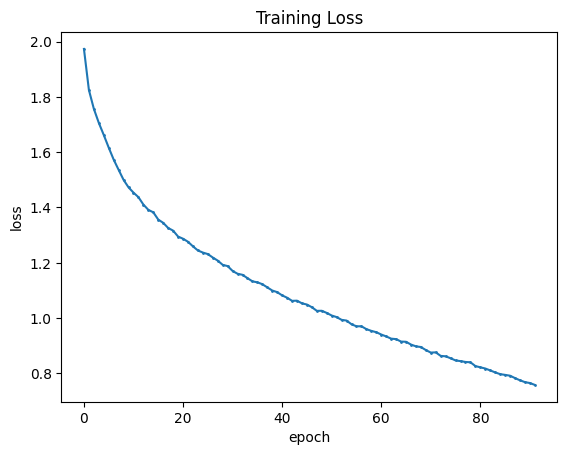

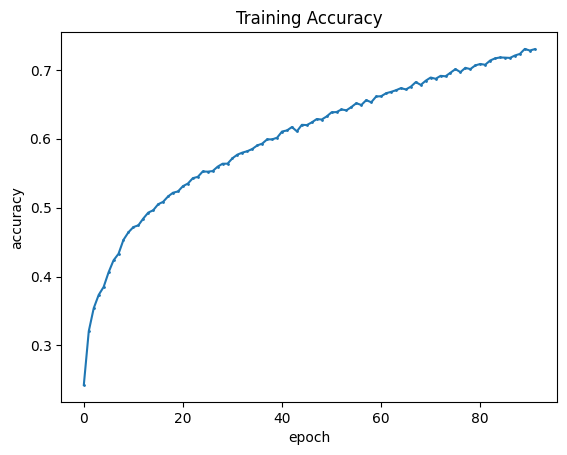

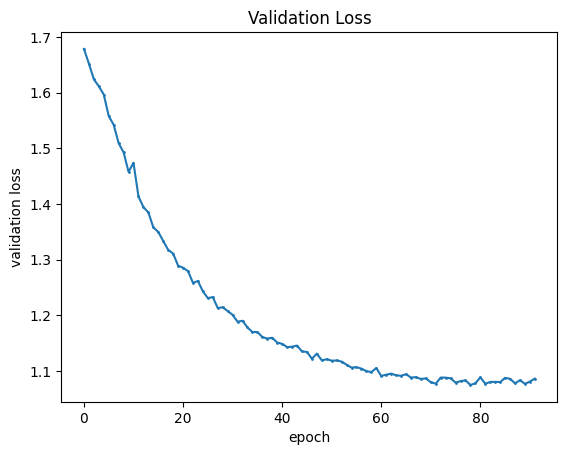

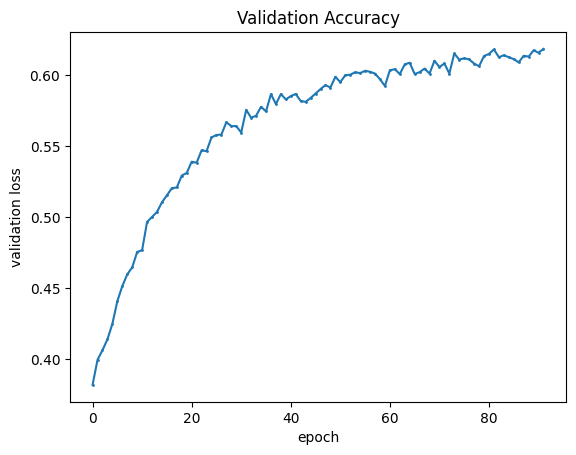

In [163]:
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy", 
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="validation loss", 
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="validation loss", 
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")

In [164]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
utility.model_validation(model, device, test_loader, m.pth_save_path)
utility.model_validation(model, device, test_loader, m.pth_manual_save_path)

Test Accuracy: 61.27054889941488%
Test Accuracy: 61.27054889941488%


In [165]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # predicted is the emotion index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 61.27054889941488%
